In [3]:
import glob
import os

import yaml
from wandb.proto import wandb_internal_pb2
from wandb.sdk.internal import datastore

params_keys = ["r", "dropout", "alpha"]
wandb_dir = "/mnt/baichuan2-lora/wandb"
params = []

summary_dict = []
for directory in glob.glob(f"{wandb_dir}/offline*/"):
    config_path = directory + "files/config.yaml"

    if not os.path.exists(config_path):
        continue

    with open(config_path, "r", encoding="utf8") as f:
        config = yaml.safe_load(f)
        if config["lr"]["value"] == 2e-4:
            continue

    param = {p: config[p]["value"] for p in params_keys if p != "lr"}
    params.append(param)
    
    start_time = float(config["_wandb"]["value"]["start_time"])

    db_file = glob.glob(directory + "*.wandb")[0]
    ds = datastore.DataStore()
    ds.open_for_scan(db_file)

    while True:
        if ds.in_last_block():
            break
        data = ds.scan_data()
        pb = wandb_internal_pb2.Record()
        pb.ParseFromString(data)
        record_type = pb.WhichOneof("record_type")

        if record_type == "history":
            tracked_value_0 = pb.history.item[0].value_json
            loss = [item.value_json for item in pb.history.item if item.key == "loss"][
                0
            ]
            ts = [
                item.value_json for item in pb.history.item if item.key == "_timestamp"
            ][0]

            summary = param.copy()
            summary['scale'] = summary['alpha'] / summary['r']
            summary.update({"loss": float(loss), "ts": float(ts) - start_time})
            summary_dict.append(summary)

print(summary_dict[0:10])
print(len(summary_dict))

[{'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 12.0, 'ts': 7.947960376739502}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 12.0, 'ts': 13.380117654800415}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 12.0, 'ts': 18.83116388320923}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 12.0, 'ts': 24.28563094139099}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.9375, 'ts': 29.747527837753296}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.9375, 'ts': 35.2169713973999}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.8125, 'ts': 40.68346548080444}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.8125, 'ts': 46.1542067527771}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.875, 'ts': 51.625128507614136}, {'r': 1, 'dropout': 0.01, 'alpha': 64, 'scale': 64.0, 'loss': 11.6875, 'ts': 57.09415936470032}]
153125


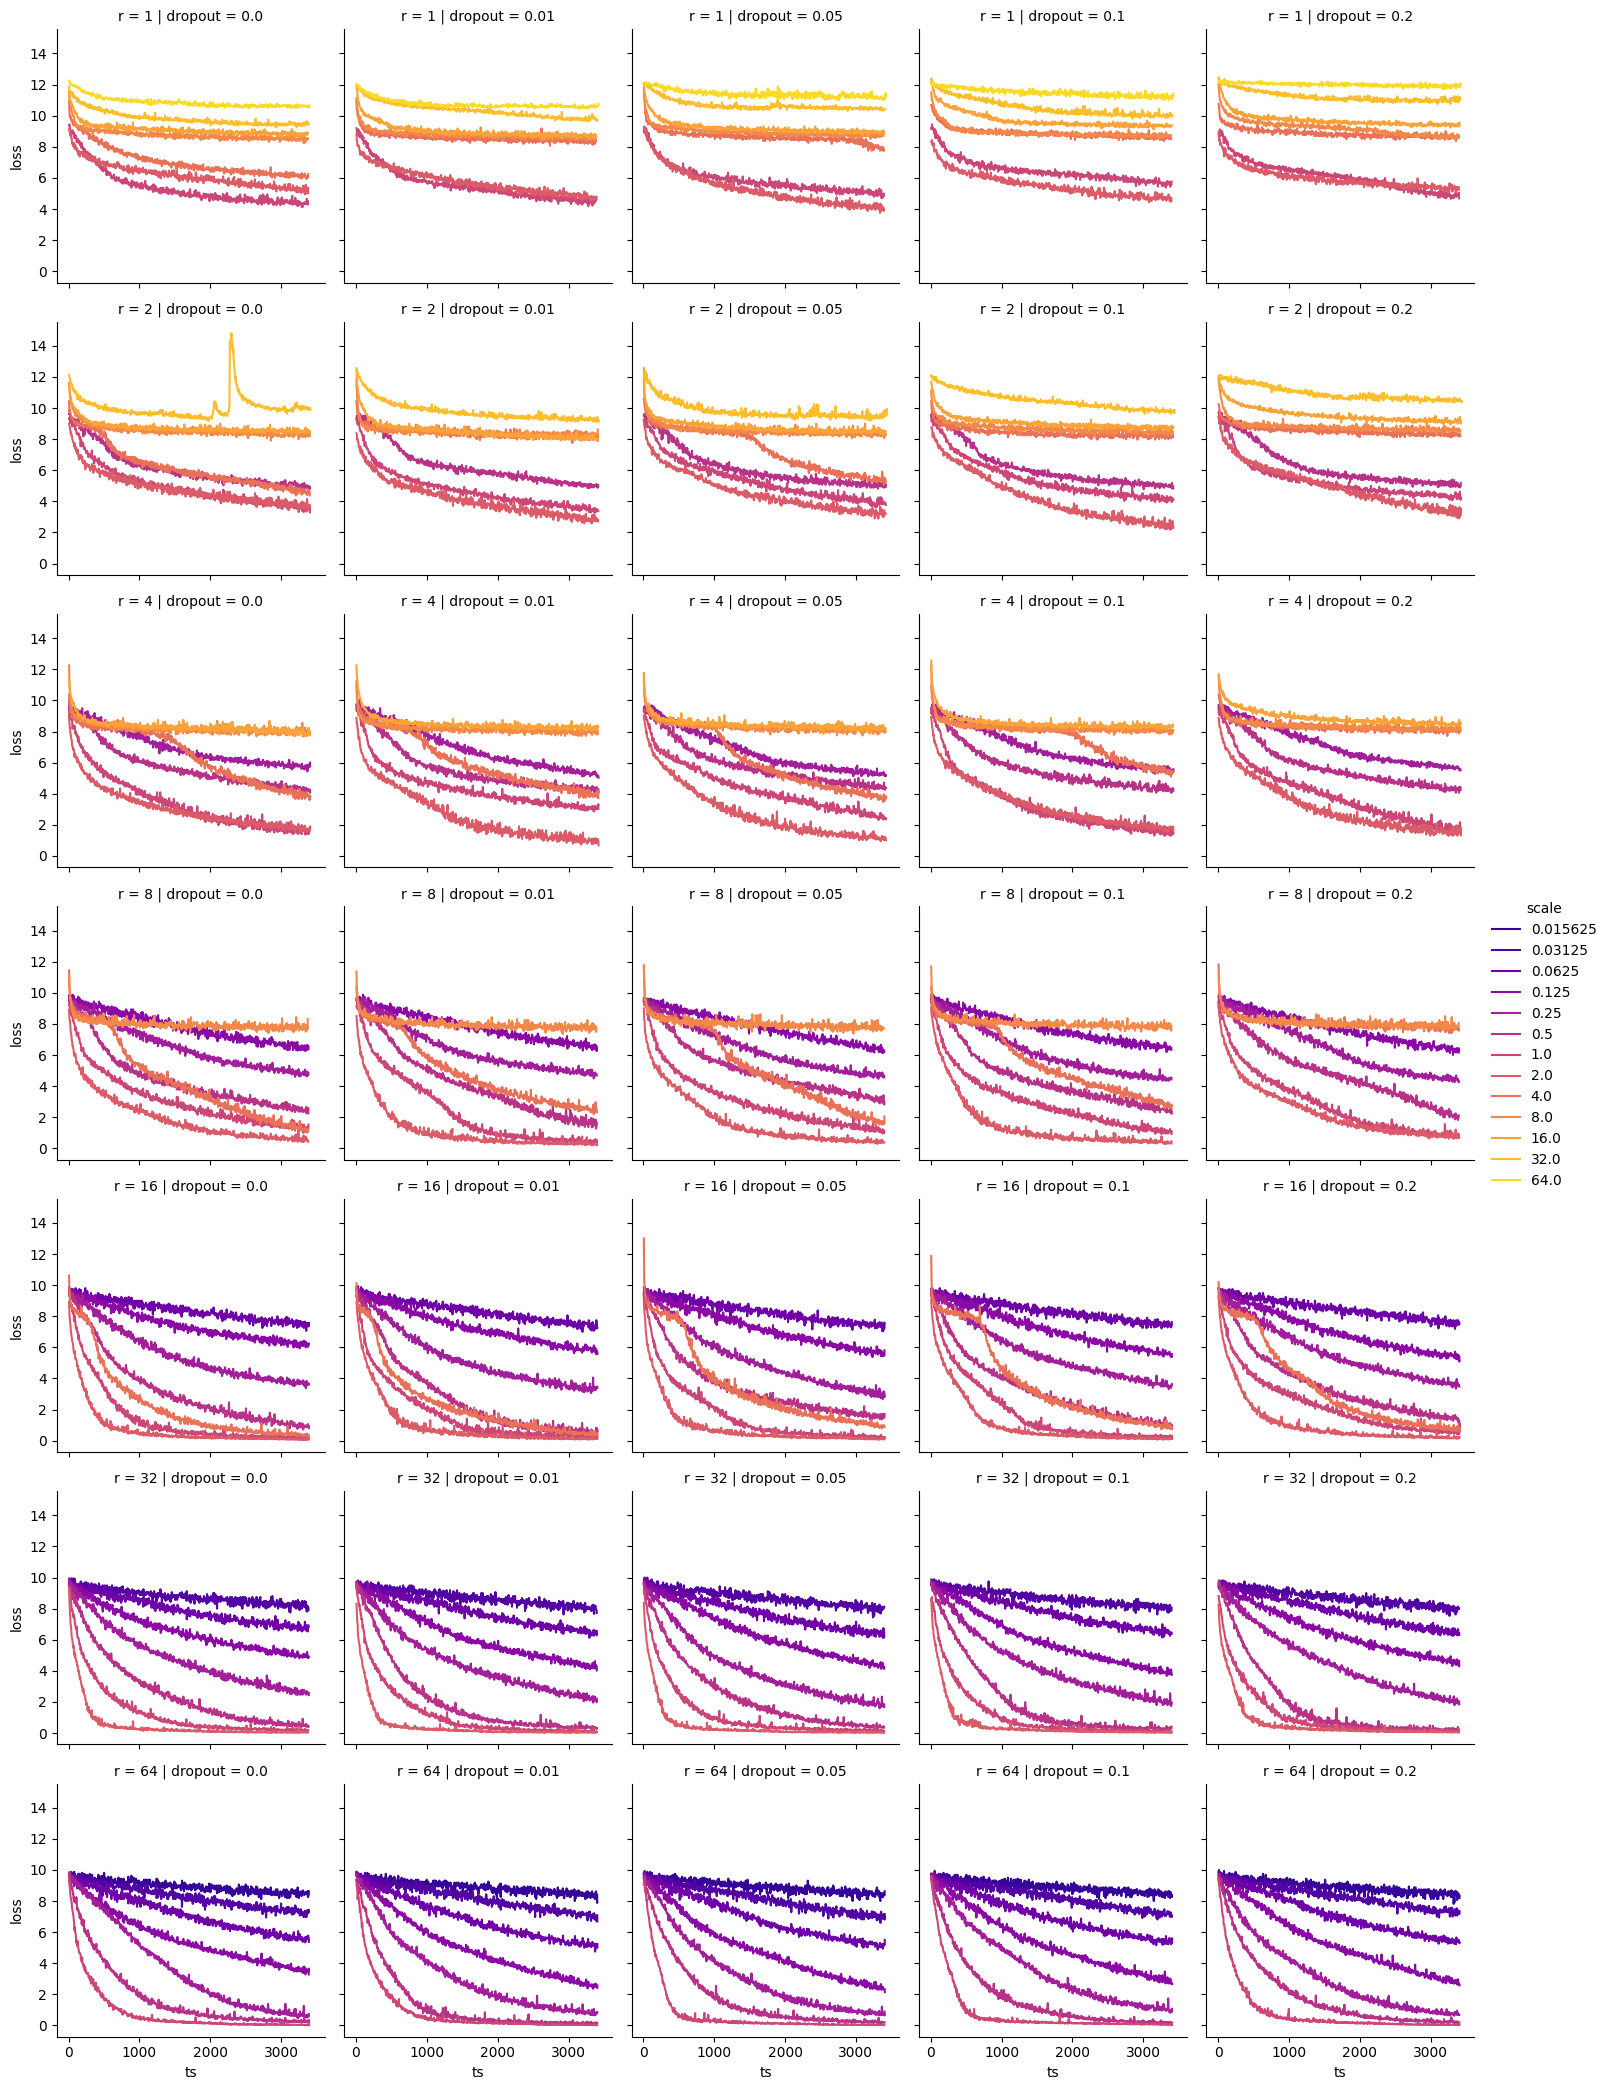

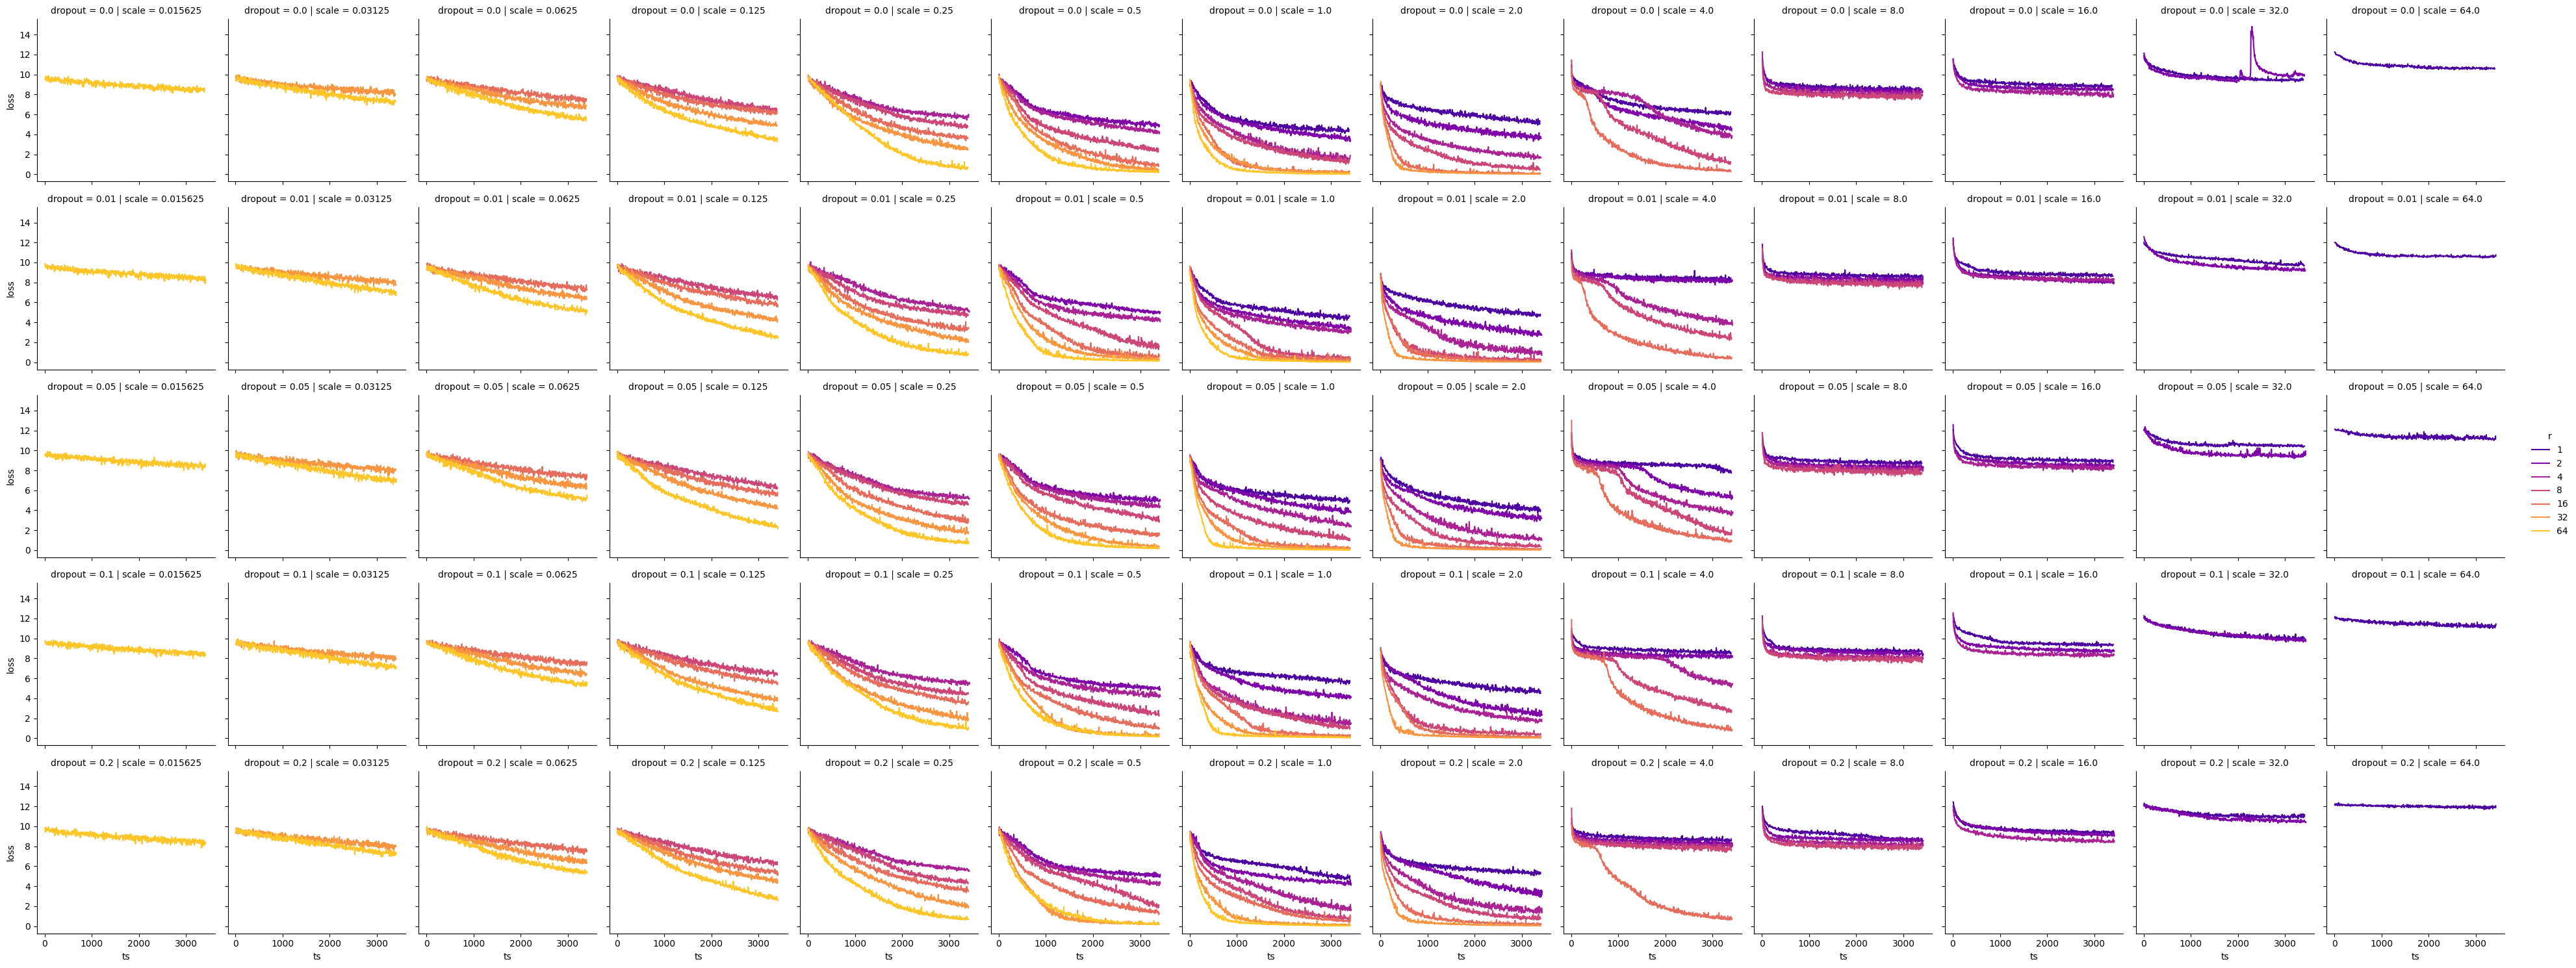

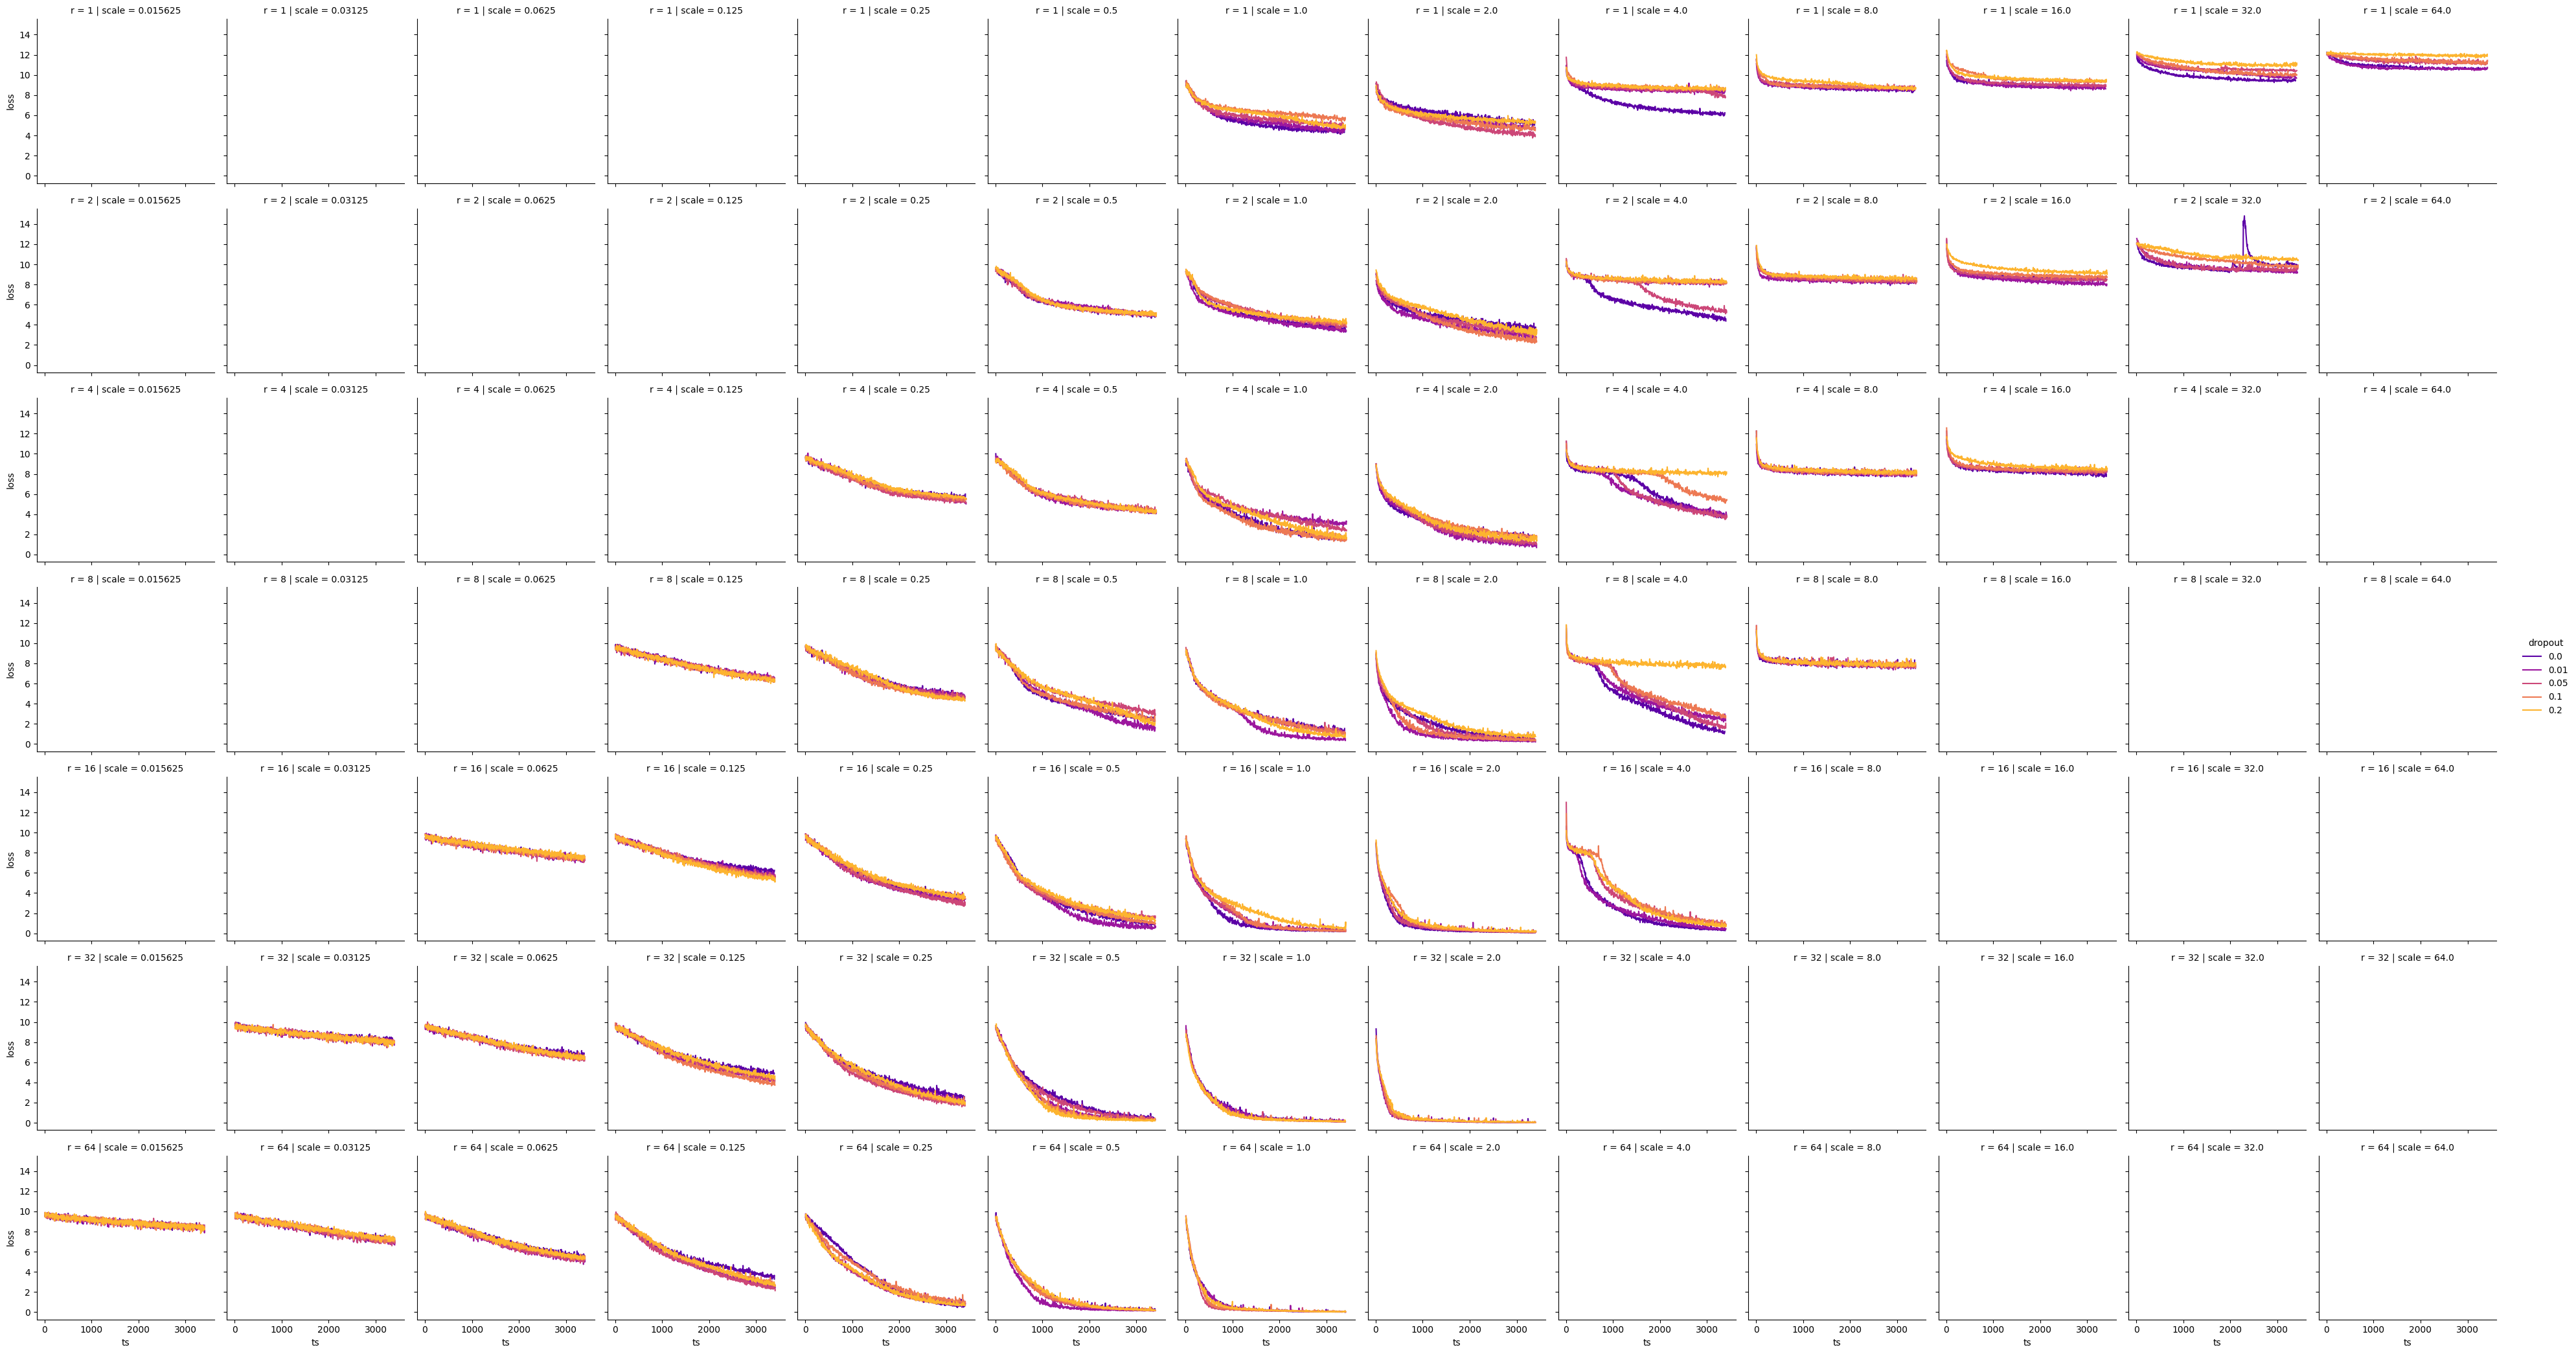

In [ ]:
import pandas as pd
import seaborn as sns
dataset = pd.DataFrame.from_dict(summary_dict)

permutations = [["r", "dropout", "scale",],["dropout", "scale", "r",],["r", "scale", "dropout",]]
for per in permutations:
    g = sns.FacetGrid(dataset, row=per[0], col=per[1], hue=per[2], palette="plasma")
    g.map(sns.lineplot, "ts", "loss")
    g.add_legend()